In [3]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import os
from sklearn.preprocessing import MinMaxScaler
from dynamics import *
import re
import math
from optread import *
#set latex font for plots
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [4]:
# Precompute embeddings for all readouts
def precompute_embeddings(datapoints_normalized):
    simulator = RydbergSimulator(
        nsites=nsites,
        atoms=atoms,
        readouts=readouts,
        omega=omega,
        t_start=t_start,
        t_end=t_end,
        t_step=t_step,
        t_rate=t_rate,
        alpha=alpha,
        V_matrix=V_matrix,
        id=0,
        use_wavelet=False
    )
    embeddings = simulator.apply_layer(datapoints_normalized)
    return readouts, embeddings

In [5]:
# Generate regression dataset
X, y = make_regression(n_samples=100, n_features=4, noise=0.1, random_state=42)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

# Select subsets for demonstration purposes
# X_train = X_train[:20]
# y_train = y_train[:20]
# X_test = X_test[:20]
# y_test = y_test[:20]

In [10]:
#use a simple random forest classifier
clf = RandomForestRegressor(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)
#accuracy
y_pred = clf.predict(X_test)
base_mse = mean_squared_error(y_test, y_pred)
print('Base Test MSE: {}'.format(base_mse))
    

Base Test MSE: 1216.9587152638278


Plot saved as lattice_plot.pdf


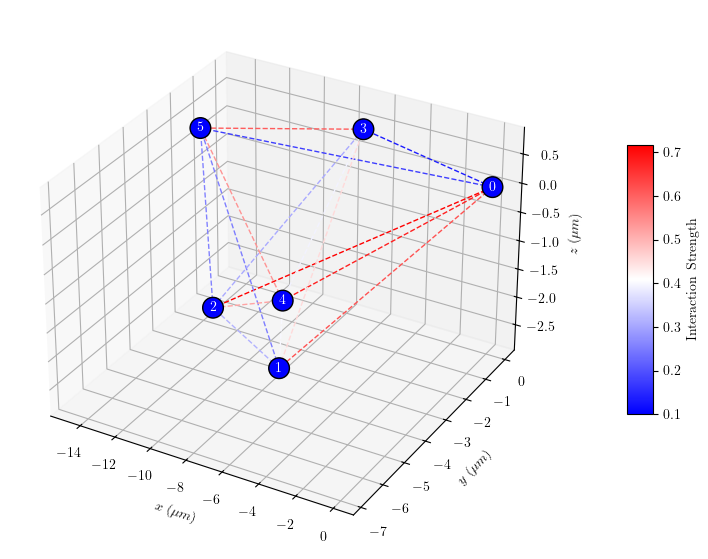

In [14]:
nsites =6
d = 10 # 10 micron spacing
atoms = np.linspace(0, (nsites - 1) * d, nsites)  # Put atoms in a chain with 10 micron spacing

# Hyperparameters for testing
omega = 2 * np.pi
t_start = 0.0
t_end = 3.0
t_step = 0.5
t_rate = 1.0
alpha = np.random.rand(nsites)  # Random site modulation factors between 0 and 1
V_matrix = np.random.rand(nsites, nsites)
V_matrix = (V_matrix + V_matrix.T) / 2  # Make the interaction matrix symmetric
np.fill_diagonal(V_matrix, 0.1)  # Set diagonal elements to 0.1
#use min-max normalization

# Call the function
plot_3d_lattice(nsites, d, atoms, alpha, V_matrix, save_as_pdf=True, filename="lattice_plot.pdf")

In [15]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_datapoints_normalized = scaler.fit_transform(X_train)
test_datapoints_normalized = scaler.transform(X_test)
#custom_readouts = ["IIIZII","ZIIIII","IZIIII","XXXIII","IIIXXX","IIIIIX"]

#readouts = generate_readouts(nsites, custom_readouts)
readouts = generate_readouts(nsites)  #default readouts

readouts, train_embeddings = precompute_embeddings(train_datapoints_normalized)
readouts, test_embeddings = precompute_embeddings(test_datapoints_normalized)
train_embeddings=train_embeddings/(2**nsites) #normalize embeddings
test_embeddings=test_embeddings/(2**nsites) #normalize embeddings

100%|██████████| 30/30 [00:15<00:00,  1.94it/s]


In [16]:
#check the mse of the embeddings
clf = RandomForestRegressor(n_estimators=50, random_state=42)
clf.fit(train_embeddings, y_train)
#accuracy   
y_pred = clf.predict(test_embeddings)
qrc_full_mse = mean_squared_error(y_test, y_pred)
print('QRC Full MSE: {}'.format(qrc_full_mse))

QRC Full MSE: 759.114297061368


In [17]:
t_steps = np.arange(t_start+t_step, t_end+t_step, t_step)
#reshape the embeddings to be in the shape of (n_samples, len(t_steps), :))
embd_per_t = train_embeddings.reshape(train_embeddings.shape[0], len(t_steps), -1)
embd_per_t_test = test_embeddings.reshape(test_embeddings.shape[0], len(t_steps), -1)

The original value of the sample is:  [-1.23086432  0.81351722 -0.32206152 -0.78325329]


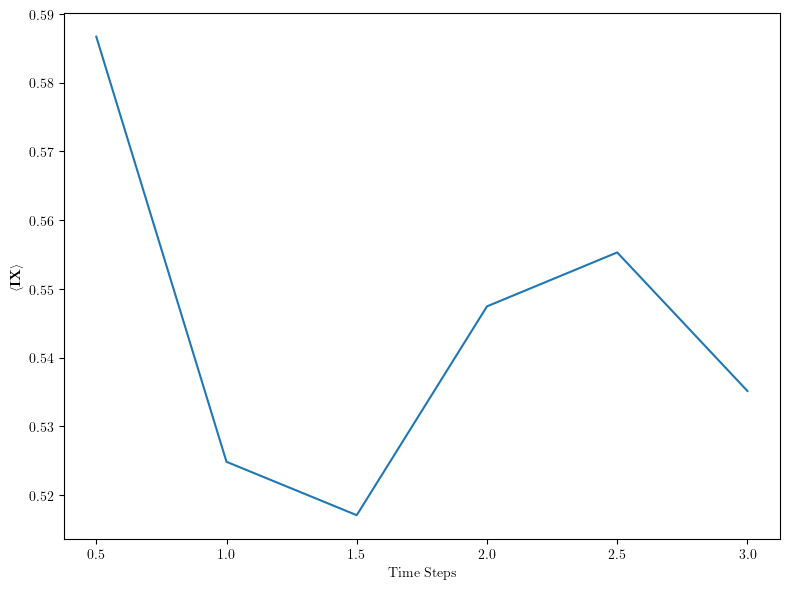

In [18]:
# Sample Index and Readout Index
sample_idx = 0
readout_idx = 1  # Specify the readout index to visualize

print("The original value of the sample is: ", X_train[sample_idx])

# Plot specific readout
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(t_steps, embd_per_t[sample_idx, :, readout_idx])

# Convert readout string to LaTeX with braket notation
readout = readouts[readout_idx].to_string()
title = re.search(r"[IXYZ]+", readout).group()
latex_title = f"$\\langle \\mathbf{{{title}}} \\rangle$"

ax.set_xlabel('Time Steps')
ax.set_ylabel(latex_title)
plt.tight_layout()
plt.show()

In [19]:
#optimize the feature selection on observable selections (readouts) (reasonable performance but faster)
retention = int(len(embd_per_t[0])*0.25) #only keep 25% of the features
results = genetic_algorithm_feature_selection(
    embd_per_t, embd_per_t_test, y_train, y_test,
    base_mse=base_mse,
    qrc_full_mse=qrc_full_mse,
    model=clf,
    pop_size=25,
    n_gen=100,
    crossover_rate=0.7,
    mutation_rate=0.2,
    elitism_count=2,
    n_jobs=-1,
    max_features_selected=retention
)

Iteration 1/100: base_mse=1216.9587, qrc_full_mse=759.1143, best_mse=806.0029
Iteration 2/100: base_mse=1216.9587, qrc_full_mse=759.1143, best_mse=712.2304
Iteration 3/100: base_mse=1216.9587, qrc_full_mse=759.1143, best_mse=712.2304
Iteration 4/100: base_mse=1216.9587, qrc_full_mse=759.1143, best_mse=712.2304
Iteration 5/100: base_mse=1216.9587, qrc_full_mse=759.1143, best_mse=712.2304
Iteration 6/100: base_mse=1216.9587, qrc_full_mse=759.1143, best_mse=712.2304
Iteration 7/100: base_mse=1216.9587, qrc_full_mse=759.1143, best_mse=712.2304
Iteration 8/100: base_mse=1216.9587, qrc_full_mse=759.1143, best_mse=712.2304
Iteration 9/100: base_mse=1216.9587, qrc_full_mse=759.1143, best_mse=712.2304
Iteration 10/100: base_mse=1216.9587, qrc_full_mse=759.1143, best_mse=487.8486
Iteration 11/100: base_mse=1216.9587, qrc_full_mse=759.1143, best_mse=487.8486
Iteration 12/100: base_mse=1216.9587, qrc_full_mse=759.1143, best_mse=487.8486
Iteration 13/100: base_mse=1216.9587, qrc_full_mse=759.1143, 

In [20]:
#optimize the feature selection on the full embeddings (performance is good but slow)
retention = int(len(train_embeddings[0])*0.25) #only keep 25% of the features
results = genetic_algorithm_feature_selection(
    train_embeddings, test_embeddings, y_train, y_test,
    base_mse=base_mse,
    qrc_full_mse=qrc_full_mse,
    model=clf,
    pop_size=25,
    n_gen=100,
    crossover_rate=0.7,
    mutation_rate=0.2,
    elitism_count=2,
    n_jobs=-1,
    max_features_selected=retention
)

Iteration 1/100: base_mse=1216.9587, qrc_full_mse=759.1143, best_mse=488.7498
Iteration 2/100: base_mse=1216.9587, qrc_full_mse=759.1143, best_mse=488.7498
Iteration 3/100: base_mse=1216.9587, qrc_full_mse=759.1143, best_mse=449.1129
Iteration 4/100: base_mse=1216.9587, qrc_full_mse=759.1143, best_mse=424.7110
Iteration 5/100: base_mse=1216.9587, qrc_full_mse=759.1143, best_mse=424.7110
Iteration 6/100: base_mse=1216.9587, qrc_full_mse=759.1143, best_mse=389.1744
Iteration 7/100: base_mse=1216.9587, qrc_full_mse=759.1143, best_mse=389.1744
Iteration 8/100: base_mse=1216.9587, qrc_full_mse=759.1143, best_mse=389.1744
Iteration 9/100: base_mse=1216.9587, qrc_full_mse=759.1143, best_mse=389.1744
Iteration 10/100: base_mse=1216.9587, qrc_full_mse=759.1143, best_mse=342.0644
Iteration 11/100: base_mse=1216.9587, qrc_full_mse=759.1143, best_mse=342.0644
Iteration 12/100: base_mse=1216.9587, qrc_full_mse=759.1143, best_mse=342.0644
Iteration 13/100: base_mse=1216.9587, qrc_full_mse=759.1143, 

In [21]:
results_dict = {}
final_info = results[-1]
best_mse = final_info['best_mse']
final_info = results[-1]
best_mask = final_info['best_mask']
improvement = (base_mse - best_mse) / base_mse * 100

results_dict[nsites] = {
    "nsites": nsites,
    "qrc_mse": qrc_full_mse,
    "best_mse": best_mse,
    "best_mask": best_mask,
    "selected_features": np.where(best_mask == 1)[0],
    "length_selected_features": len(np.where(best_mask == 1)[0]),
    "original_length": len(train_embeddings[0]),
    "improvement": improvement
}

In [22]:
# final results is a list of dicts for each iteration
# The last entry has the best overall
final_info = results[-1]
print("\n=== FINAL GA RESULTS ===")
print(f"Iteration: {final_info['iteration']}")
print(f"Best MSE: {final_info['best_mse']:.4f}")
best_mask = final_info['best_mask']
#print("Features selected:", np.where(best_mask == 1)[0])
#print selcted feature out of tiotal features
selected_features = np.where(best_mask == 1)[0]
print(len(selected_features))


=== FINAL GA RESULTS ===
Iteration: 100
Best MSE: 303.8485
162


In [23]:
regressor_QRC = clf
regressor_QRC.fit(train_embeddings[:,selected_features], y_train)
train_preds_QRC = regressor_QRC.predict(train_embeddings[:,selected_features])
test_preds_QRC = regressor_QRC.predict(test_embeddings[:,selected_features])
mean_squared_error(y_test, test_preds_QRC)

303.84848674671036

In [24]:
#the improvement in mse
improvement = (base_mse - mean_squared_error(y_test, test_preds_QRC)) / base_mse * 100
print('QRC Test MSE: {}'.format(mean_squared_error(y_test, test_preds_QRC)))
print('QRC Improvement: {:.2f}%'.format(improvement))

QRC Test MSE: 303.84848674671036
QRC Improvement: 75.03%
